Hunter Bennett | Glass Lab | Brain Aging Project | 12 Feb 2021  

The goal of this notebook is to compare the nucleosome free regions called by HOMER and HisTrader to the nucleosome free regions defined by ATAC-seq. This will inform the analysis in other cell types and determine whether we can uce the H3K27Ac defined NFR regions for motif finding.

In [33]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib_venn import venn2
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ATAC/Microglia/'
workingDirectory = '/home/h1bennet/brain_aging/results/00_Microglia_CompareATACNFR/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Copy in peak files from other analyses

In [5]:
if not os.path.isdir('./peak_files'):
    os.mkdir('./peak_files')

### First copy in the NFR peaks

In [ ]:
%%bash
cp ../00_PU1_H3K27Ac_4month_vs_25month/merged_peaks/nfr_peaks_merged.txt \
./peak_files/

### Next copy in the IDR peaks

In [ ]:
%%bash
cp ../00_Microglia_ATAC/merged_peaks/idr_peaks_merged.txt
./peak_files/

# Use homer mergePeaks to check for overlap

In [7]:
%%bash

cd ./peak_files/

mergePeaks -prefix merge -matrix overlap_matrix \
idr_peaks_merged.txt nfr_peaks_merged.txt \
> idr_nfr_peaks_merged.txt

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing idr_peaks_merged.txt (119988 total) and idr_peaks_merged.txt (119988 total)
	Comparing idr_peaks_merged.txt (119988 total) and nfr_peaks_merged.txt (105306 total)
	Comparing nfr_peaks_merged.txt (105306 total) and idr_peaks_merged.txt (119988 total)
	Comparing nfr_peaks_merged.txt (105306 total) and nfr_peaks_merged.txt (105306 total)

idr_peaks_merged.txt	nfr_peaks_merged.txt	Total	Name
	X	61683	nfr_peaks_merged.txt
X		77918	idr_peaks_merged.txt
X	X	38516	idr_peaks_merged.txt|nfr_peaks_merged.txt


The overlap here is pretty bad - only about 1/3 of the idr ATAC peaks overlap HOMER NFR peaks. This led us to go looking for other technologies to predict ATAC-seq peaks, we then found HisTrader!

# Prep NFR predictions using HisTrader
___
Histrader requires two inputs to do NFR predictions:
1. BedGraph style peak data.
2. Bed file "broadPeaks" or homer -regions within which to perform NFR predictions.

The easiest way to evaluate the NFR predictions in my view is to predict the NFR within differentially acetylated variable width regions as defined by HOMER, we can then compare those as well as the HOMER defined NFR to the ATAC-seq peaks as "ground truth"

## Generate bedGraphs using HOMER

In [ ]:
if not os.path.isdir('./bedGraphs'):
    os.mkdir('./bedGraphs')

In [ ]:
%%bash

makeUCSCfile ../00_Microglia_H3K27Ac/merged_tagdirs/00_all_microglia_H3K27Ac_4months/ \
-o ./bedGraphs/00_all_microglia_H3K27Ac_4months

gunzip ./bedgraphs/00_all_microglia_H3K27Ac_4months.bedGraph.gz

makeUCSCfile ../00_Microglia_H3K27Ac/merged_tagdirs/01_all_microglia_H3K27Ac_25months/ \
-o ./bedGraphs/01_all_microglia_H3K27Ac_25months

gunzip ./bedgraphs/01_all_microglia_H3K27Ac_25months.bedGraph.gz

## Copy over differentially acetylated regions (in bed format)

In [8]:
if not os.path.isdir('./differential_bed'):
    os.mkdir('./differential_bed')

In [9]:
!ls differential_bed/

00_pu1_4month_act_peaks.bed  01_pu1_25month_act_peaks.bed


In [12]:
ls ../00_PU1_H3K27Ac_4month_vs_25month/bed_files/

00_pu1_4month_nfr_act_background.bed
00_pu1_4month_nfr_act_background_distal.bed
00_pu1_4month_nfr_act_peaks.bed
00_pu1_4month_nfr_act_peaks_distal.bed
00_pu1_4month_union_act_peaks.bed
00_pu1_4month_union_act_peaks_distal.bed
01_pu1_25month_nfr_act_background.bed
01_pu1_25month_nfr_act_background_distal.bed
01_pu1_25month_nfr_act_peaks.bed
01_pu1_25month_nfr_act_peaks_distal.bed
01_pu1_25month_union_act_peaks.bed
01_pu1_25month_union_act_peaks_distal.bed
fw_peaks_merged.bed
nfr_peaks_merged.bed
vw_peaks_merged.bed


In [15]:
%%bash

cp ../00_PU1_H3K27Ac_4month_vs_25month/bed_files/00_pu1_4month_union_act_peaks.bed \
./differential_bed/00_pu1_4month_act_peaks.bed

cp ../00_PU1_H3K27Ac_4month_vs_25month/bed_files/01_pu1_25month_union_act_peaks.bed \
./differential_bed/01_pu1_25month_act_peaks.bed

## Run HisTrader

In [16]:
%%bash

perl ~/code/HisTrader/Histrader.pl \
--bedGraph ./bedGraphs/00_all_microglia_H3K27Ac_4months.bedGraph \
--peaks ./differential_bed/00_pu1_4month_act_peaks.bed \
--out ./00_pu1_4month_act_histrader

mv ./00_pu1_4month_act_histrader* ./histrader/



########################################################################################################
##                                                                                                    ##
##    HISTRADER: A tool to identify nucleosome free regions from ChIP-Seq of Histone Modifications    ##
##                                                                                                    ##
##                                                                                                    ##
##                                Written by Yifei Yan and Swneke D. Bailey                           ##
##                                   Copyright 2020 Swneke D. Bailey                                  ##
##                                                                                                    ##
########################################################################################################


Identifying Valleys in ./bedGraphs/00_all_microglia

In [ ]:
%%bash

perl ~/code/HisTrader/Histrader.pl \
--bedGraph ./bedGraphs/01_all_microglia_H3K27Ac_25months.bedGraph \
--peaks ./differential_bed/01_pu1_25month_act_peaks.bed \
--out ./01_pu1_25month_act_histrader

mv ./01_pu1_25month_act_histrader* ./histrader/

### Label histrader bed files for upload to UCSC

In [4]:
%%bash

echo 'track name="histrader_microglia_4month_nfr" description="HisTrader NFR regions in 4 month Microglia H3K27Ac"' \
| cat - ./histrader/00_pu1_4month_act_histrader.nfr.bed \
> temp && mv temp ./histrader/00_pu1_4month_act_histrader.nfr.bed

echo 'track name="histrader_microglia_25month_nfr" description="HisTrader NFR regions in 25 month Microglia H3K27Ac"' \
| cat - ./histrader/01_pu1_25month_act_histrader.nfr.bed \
> temp && mv temp ./histrader/01_pu1_25month_act_histrader.nfr.bed

## TODO:
1. Pull ATAC-seq peaks within these regions using bedtools
2. Use merge peaks to compare NFR regions called by HOMER and HisTrader to ATAC-seq peaks.
3. Visualize on browser.

## Pull HOMER peaks and ATAC-seq (ground truth) peaks from regions using bedtools
___
These were already stored in this folder in the ./peak_files/ directory under idr_peaks_merged.txt

In [5]:
if not os.path.isdir('./bed_files'):
    os.mkdir('./bed_files')

convert all peak files into bed files

In [10]:
%%bash
# delete the existing script file
rm ./peak_to_bed.sh
# create a script file
touch ./peak_to_bed.sh

In [11]:
%%bash
for peakfile in ./peak_files/*merged.txt;
do out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed.sh
done

In [12]:
%%bash

bedtools intersect -wa -a ./bed_files/idr_peaks_merged.bed \
-b ./differential_bed/00_pu1_4month_act_peaks.bed \
> ./differential_bed/00_pu1_4month_idr_peaks.bed

bedtools intersect -wa -a ./bed_files/idr_peaks_merged.bed \
-b ./differential_bed/01_pu1_25month_act_peaks.bed \
> ./differential_bed/01_pu1_25month_idr_peaks.bed

bedtools intersect -wa -a ./bed_files/nfr_peaks_merged.bed \
-b ./differential_bed/00_pu1_4month_act_peaks.bed \
> ./differential_bed/00_pu1_4month_nfr_peaks.bed

bedtools intersect -wa -a ./bed_files/nfr_peaks_merged.bed \
-b ./differential_bed/01_pu1_25month_act_peaks.bed \
> ./differential_bed/01_pu1_25month_nfr_peaks.bed

### Label these for browser

In [13]:
%%bash

echo 'track name="ATAC_microglia_4month_nfr" description="ATAC NFR regions in 4 month Microglia H3K27Ac"' \
| cat - ./differential_bed/00_pu1_4month_idr_peaks.bed \
> temp && mv temp ./differential_bed/00_pu1_4month_idr_peaks.bed

echo 'track name="ATAC_microglia_25month_nfr" description="ATAC NFR regions in 25 month Microglia H3K27Ac"' \
| cat - ./differential_bed/01_pu1_25month_idr_peaks.bed \
> temp && mv temp ./differential_bed/01_pu1_25month_idr_peaks.bed

echo 'track name="HOMER_microglia_4month_nfr" description="HOMER NFR regions in 4 month Microglia H3K27Ac"' \
| cat - ./differential_bed/00_pu1_4month_nfr_peaks.bed \
> temp && mv temp ./differential_bed/00_pu1_4month_nfr_peaks.bed

echo 'track name="HOMER_microglia_25month_nfr" description="HOMER NFR regions in 25 month Microglia H3K27Ac"' \
| cat - ./differential_bed/01_pu1_25month_nfr_peaks.bed \
> temp && mv temp ./differential_bed/01_pu1_25month_nfr_peaks.bed

# Compare peaks directly using mergePeaks

In [17]:
if not os.path.isdir('./differential_peaks'):
    os.mkdir('./differential_peaks')

In [25]:
%%bash
# delete the existing script file
rm ./bed_to_peak.sh
# create a script file
touch ./bed_to_peak.sh

In [26]:
%%bash
for bedfile in ./differential_bed/*.bed;
do out=${bedfile/.bed/.txt};
out=${out/differential_bed/differential_peaks}
echo "bed2pos.pl -o $out $bedfile" >> ./bed_to_peak.sh
done

for bedfile in ./histrader/*.nfr.bed;
do out=${bedfile/.bed/.txt};
out=${out/histrader/differential_peaks}
echo "bed2pos.pl -o $out $bedfile" >> ./bed_to_peak.sh
done

In [28]:
if not os.path.isdir('./merge_peaks_output'):
    os.mkdir('./merge_peaks_output')

### 4 month peaks

HisTrader peaks

In [29]:
%%bash

mergePeaks -prefix merge_peaks_output/histrader_4month \
-matrix merge_peaks_output/histrader_4month_overlap_matrix \
./differential_peaks/00_pu1_4month_act_histrader.nfr.txt \
./differential_peaks/00_pu1_4month_idr_peaks.txt \

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Duplicate peak name (chr1:13295958-13297650) - this could potentially cause problems
		Sometimes unavoidable for BED/2DBED formats
		New name for this peak is chr1:13295958-13297650--2
		Warning over 1000 peaks with duplicate names
	Comparing ./differential_peaks/00_pu1_4month_act_histrader.nfr.txt (2108 total) and ./differential_peaks/00_pu1_4month_act_histrader.nfr.txt (2108 total)
	Comparing ./differential_peaks/00_pu1_4month_act_histrader.nfr.txt (2108 total) and ./differential_peaks/00_pu1_4month_idr_peaks.txt (666 total)
	Comparing ./differential_peaks/00_pu1_4month_idr_peaks.txt (666 total) and ./differential_peaks/00_pu1_4month_act_histrader.nfr.txt (2108 total)
	Comparing ./differential_peaks/00_pu1_4month_idr_peaks.txt (666 total) and ./differential_peaks/00_pu1_4month_idr_peaks.txt (666 total)

./differential_peaks/00_pu1_4month_act_histrader.nfr.txt	./differential_peaks/00_pu1_4month_idr_peaks.tx

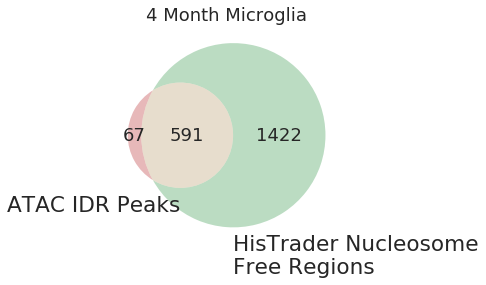

In [44]:
fig, ax = plt.subplots(figsize=(8,4))

venn2(subsets={'10': 67,
               '01': 1422,
               '11': 591},
      set_labels=('ATAC IDR Peaks',
                  'HisTrader Nucleosome\nFree Regions'),
      ax=ax)

ax.set_title('4 Month Microglia');

Homer -NFR peaks

In [31]:
%%bash

mergePeaks -prefix merge_peaks_output/homer_4month \
-matrix merge_peaks_output/homer_4month_overlap_matrix \
./differential_peaks/00_pu1_4month_nfr_peaks.txt \
./differential_peaks/00_pu1_4month_idr_peaks.txt \

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing ./differential_peaks/00_pu1_4month_nfr_peaks.txt (895 total) and ./differential_peaks/00_pu1_4month_nfr_peaks.txt (895 total)
	Comparing ./differential_peaks/00_pu1_4month_nfr_peaks.txt (895 total) and ./differential_peaks/00_pu1_4month_idr_peaks.txt (666 total)
	Comparing ./differential_peaks/00_pu1_4month_idr_peaks.txt (666 total) and ./differential_peaks/00_pu1_4month_nfr_peaks.txt (895 total)
	Comparing ./differential_peaks/00_pu1_4month_idr_peaks.txt (666 total) and ./differential_peaks/00_pu1_4month_idr_peaks.txt (666 total)

./differential_peaks/00_pu1_4month_nfr_peaks.txt	./differential_peaks/00_pu1_4month_idr_peaks.txt	Total	Name
	X	234	./differential_peaks/00_pu1_4month_idr_peaks.txt
X		438	./differential_peaks/00_pu1_4month_nfr_peaks.txt
X	X	402	./differential_peaks/00_pu1_4month_nfr_peaks.txt|./differential_peaks/00_pu1_4month_idr_peaks.txt


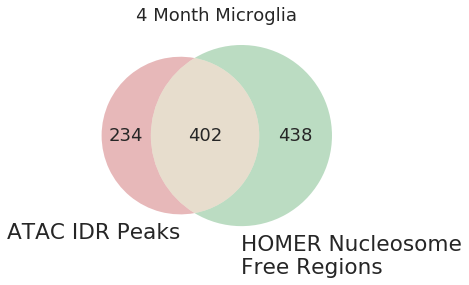

In [43]:
fig, ax = plt.subplots(figsize=(8,4))

venn2(subsets={'10': 234,
               '01': 438,
               '11': 402},
      set_labels=('ATAC IDR Peaks',
                  'HOMER Nucleosome\nFree Regions'),
      ax=ax)

ax.set_title('4 Month Microglia');

In [55]:
overlap_25mo = [1345, 1343, 1205, 543, 130, 5]
histrader_only_25mo = [3346, 3231, 1872, 550, 68, 1]
total_histrader_25mo = []
for i, j in zip(overlap_25mo, histrader_only_25mo):
    total_histrader_25mo.append(i+j)

### 25month

In [30]:
%%bash

mergePeaks -prefix merge_peaks_output/histrader_25month \
-matrix merge_peaks_output/histrader_4month_overlap_matrix \
./differential_peaks/01_pu1_25month_act_histrader.nfr.txt \
./differential_peaks/01_pu1_25month_idr_peaks.txt \

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Duplicate peak name (chr1:23259853-23261118) - this could potentially cause problems
		Sometimes unavoidable for BED/2DBED formats
		New name for this peak is chr1:23259853-23261118--2
		Warning over 1000 peaks with duplicate names
		Warning over 2000 peaks with duplicate names
		Warning over 3000 peaks with duplicate names
	Comparing ./differential_peaks/01_pu1_25month_act_histrader.nfr.txt (4947 total) and ./differential_peaks/01_pu1_25month_act_histrader.nfr.txt (4947 total)
	Comparing ./differential_peaks/01_pu1_25month_act_histrader.nfr.txt (4947 total) and ./differential_peaks/01_pu1_25month_idr_peaks.txt (1601 total)
	Comparing ./differential_peaks/01_pu1_25month_idr_peaks.txt (1601 total) and ./differential_peaks/01_pu1_25month_act_histrader.nfr.txt (4947 total)
	Comparing ./differential_peaks/01_pu1_25month_idr_peaks.txt (1601 total) and ./differential_peaks/01_pu1_25month_idr_peaks.txt (1601 total)

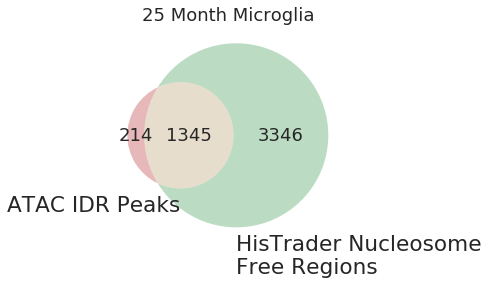

In [45]:
fig, ax = plt.subplots(figsize=(8,4))

venn2(subsets={'10': 214,
               '01': 3346,
               '11': 1345},
      set_labels=('ATAC IDR Peaks',
                  'HisTrader Nucleosome\nFree Regions'),
      ax=ax)

ax.set_title('25 Month Microglia');

Homer -NFR peaks

In [32]:
%%bash

mergePeaks -prefix merge_peaks_output/homer_25month \
-matrix merge_peaks_output/homer_25month_overlap_matrix \
./differential_peaks/01_pu1_25month_nfr_peaks.txt \
./differential_peaks/01_pu1_25month_idr_peaks.txt \

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing ./differential_peaks/01_pu1_25month_nfr_peaks.txt (2202 total) and ./differential_peaks/01_pu1_25month_nfr_peaks.txt (2202 total)
	Comparing ./differential_peaks/01_pu1_25month_nfr_peaks.txt (2202 total) and ./differential_peaks/01_pu1_25month_idr_peaks.txt (1601 total)
	Comparing ./differential_peaks/01_pu1_25month_idr_peaks.txt (1601 total) and ./differential_peaks/01_pu1_25month_nfr_peaks.txt (2202 total)
	Comparing ./differential_peaks/01_pu1_25month_idr_peaks.txt (1601 total) and ./differential_peaks/01_pu1_25month_idr_peaks.txt (1601 total)

./differential_peaks/01_pu1_25month_nfr_peaks.txt	./differential_peaks/01_pu1_25month_idr_peaks.txt	Total	Name
	X	592	./differential_peaks/01_pu1_25month_idr_peaks.txt
X		1154	./differential_peaks/01_pu1_25month_nfr_peaks.txt
X	X	932	./differential_peaks/01_pu1_25month_nfr_peaks.txt|./differential_peaks/01_pu1_25month_idr_peaks.txt


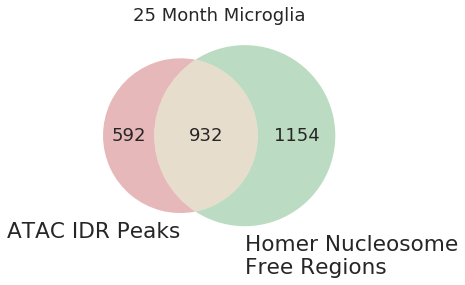

In [46]:
fig, ax = plt.subplots(figsize=(8,4))

venn2(subsets={'10': 592,
               '01': 1154,
               '11': 932},
      set_labels=('ATAC IDR Peaks',
                  'Homer Nucleosome\nFree Regions'),
      ax=ax)

ax.set_title('25 Month Microglia');

It seems like HisTrader is better than HOMER at identifying proper NFRs but has a poor false + rate. Perhaps we could annotate the HisTrader peaks with H3K27Ac signal and see if filtering ones with low H3K27Ac signal lowers the false positive rate?